# COMP0114. Literature Study CW3
#### Student ID: 18145399
## Reconstruction with Sparsity Constraints
### 1. Critical Analysis
#### Influential
Paper [1] by Candès, Romberg, and Tao, which was published in 2005, has had a significant impact on the field of compressed sensing and sparse signal recovery. The paper introduced the concept of using $\ell_1$-regularization to recover sparse signals from incomplete and noisy measurements, which has become a standard technique used in various applications.

The paper provides theoretical guarantees for the accuracy of the recovery method under certain conditions on the measurement matrix and the sparsity of the signal. It also demonstrates that the $\ell_1$-regularization method can recover approximately sparse signals, which has important practical implications.

As of March 2023, the paper has been cited 8,487 times according to Google Scholar, indicating its significance in the field. The paper has also led to numerous follow-up works that have further extended and refined the theory and applications of compressed sensing, resulting in high citation numbers for those works as well.

Overall, the paper [1] has had a highly influential impact on research and practical applications in various fields, including computer science, electrical engineering, mathematics, and physics. Its continued citation and impact over the years further demonstrate its significance and lasting contribution to the field.

The paper by J. Wright, A. Y. Yang, A. Ganesh, S. S. Sastry, and Y. Ma, titled _"Robust Face Recognition via Sparse Representation,"_ is an example of a paper that cites the influential paper [1] by Candès, Romberg, and Tao. The paper builds on the framework introduced in [1] by applying the idea of sparse signal representation to the problem of face recognition in the presence of varying expressions, illumination, occlusion, and disguise.

The paper has been cited 7,369 times (as of March 2023), indicating its significant impact in the field of computer vision and pattern recognition. The paper proposed a general classification algorithm for object recognition based on a sparse representation computed using $\ell_1$-minimization. The proposed framework provided insights into feature extraction and robustness to occlusion, showing that unconventional features such as downsampled images and random projections perform just as well as conventional features such as eigenfaces and Laplacianfaces.

Moreover, the paper proposed a method to handle errors due to occlusion and corruption by exploiting the sparsity of these errors with respect to the standard (pixel) basis. The theory of sparse representation helped predict how much occlusion the recognition algorithm can handle and how to choose the training images to maximize robustness to occlusion.

Overall, the paper has had a significant impact on the field of face recognition and pattern recognition. Its high citation count and the extensive experiments conducted to validate the proposed algorithm and claims demonstrate its practical importance and impact. The paper is an example of how the ideas presented in [1] have been applied and extended to various domains, further highlighting the significance of the original paper in the field of compressed sensing and sparse signal recovery.


#### Exactly reconstruction of signal from a discrete set of samples
A signal can be exactly reconstructed from a discrete set of samples if the samples satisfy the Nyquist-Shannon sampling theorem, which states that the sampling rate must be at least twice the maximum frequency component in the signal. In other words, if the signal is bandlimited, meaning that its frequency content is limited to a certain range, then it can be exactly reconstructed from its samples.

However, if the samples are incomplete or contaminated with noise, then exact reconstruction may not be possible. In this case, the conditions under which exact recovery is possible depend on the properties of the sampling matrix $A$ and the sparsity of the signal $x_0$. If $A$ satisfies certain conditions such as a uniform uncertainty principle and x0 is sufficiently sparse, then exact or nearly exact recovery is possible through the use of $l1$-regularization techniques. For example, if $A$ is a Gaussian random matrix, then stable recovery can occur for almost all such $A$'s provided that the number of nonzeros in $x_0$ is of about the same order as the number of observations. Similarly, if one observes only a few Fourier samples of $x_0$, stable recovery can occur for almost any set of n coefficients provided that the number of nonzeros is of the order of  $n/[\log m]^6$.

### 2. Numerical Experiments
To reproduce the results in Part 3 of the paper, follow the steps outlined on page 8 of the paper:
* First, generate a random n by m matrix $A$ (where $n <= m$). 
* Then create an original signal $x_0$ that is sparsely populated with non-zero entries. 
* Calculate $y = Ax_0 + e$ where $e$ represents noise terms added to our observations. 
* Finally, use the 1-regularization problem as described in the paper to recover $x_0$ from incomplete and contaminated observations $y$. This should result in stable recovery for almost all such matrices provided there are enough nonzeros present in $x_0$.

To solve the problem
$$ \min ‖f‖_1   \text{,    subject to  } ‖Af −y‖_2 ≤ \epsilon, $$
where $y$ is a $300 × 1$ vector $A$ is a $300 × 1024$ matrix and $f$ is a $1024 × 1$ vector, we can follow the method outlined in the paper as described above.

The singular spectrum of the matrix $A$ used for reproducing is described as a designed singular value matrix $W$ with dimensions $1024 × 1024$, where the singular values decay exponentially with index. To construct the matrix $A$, two random orthogonal bases $U$ and $V$ are multiplied by $W$, such that $A = U * W * V^T$. Since $A$ is a $300 × 1024$ matrix, its singular values will be non-zero for the first $300$ indices and zero for the remaining $724$ indices. Therefore, original matrix $A$ has the singular spectrum of $exp(-k/10)$ where $k$ is $300$.

#### Solve Basis Pursuit De-Noising problem with noise

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import cvxpy as cp


# construct matrix A
A = np.random.randn(300,1024)
U = scipy.linalg.orth(A) #(300, 300)
V = scipy.linalg.orth(np.transpose(A)) #(1024, 300)
# singular values are decreasing exponentially with a decay rate of 10
W = np.diag(np.exp(-np.arange(300)/10)) #(300, 300)
A = np.dot(np.dot(U, W), V.T) #(300, 1024)

# Set parameters
m = 1024
n = 300
k = 50
lam = 2
sigmas = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5])
num_trials = 10

In [10]:
errors = []
epsilons = []

for sigma in sigmas:
    error_sum = 0
    for j in range(num_trials):
        # Generate sparse 1D signals f0 with 50 nonzero components
        f0 = np.zeros(m) # 1024
        np.random.seed(0)
        indices = np.random.choice(m, k, replace=False)
        f0[indices] = np.random.choice([-1, 1], k)

        # Generate error e with desired mean and standard deviation
        mean_chi2 = sigma**2 * n  # mean of chi-square distribution
        std_chi2 = sigma**2 * np.sqrt(2*n)  # standard deviation of chi-square distribution
        e = np.random.randn(n) * sigma
        e_norm2 = np.linalg.norm(e)**2
        e *= np.sqrt(mean_chi2 / e_norm2)

        # Normalize e to have desired mean and standard deviation of chi-square distribution
        e_norm2 = np.linalg.norm(e)**2
        e *= np.sqrt(mean_chi2 / e_norm2)
        e *= std_chi2 / np.sqrt(e_norm2)

        # Solve Basis Pursuit Denoising problem
        epsilon = np.sqrt(sigma**2 * (n + lam*np.sqrt(2*n)))
        
        f = cp.Variable(m)
        objective = cp.Minimize(cp.norm(f, 1))
        constraints = [cp.norm(A @ f - A @ f0 - e, 2) <= epsilon]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.ECOS)

        # Compute error
        try:
            if f.value is not None:
                error = np.linalg.norm(f0 - f.value, 2) / np.linalg.norm(f0, 2)
                # error = l2distance(f0, f.value)
                error_sum += error
            else:
                print("Optimization problem did not converge.")
        except cp.error.SolverError:
            print("Solver error occurred. Please check the optimization problem formulation.")
        
        
    # Compute average error over all trials
    epsilons.append(epsilon)
    errors.append(error_sum / num_trials)

# Print results
print("sigmas:", sigmas)
print("epsilons:", epsilons)
print("errors:", errors)

sigmas: [0.01 0.02 0.05 0.1  0.2  0.5 ]
epsilons: [0.18681268555846617, 0.37362537111693234, 0.9340634277923309, 1.8681268555846617, 3.7362537111693235, 9.340634277923309]
errors: [1.043749633382624, 1.0031405633933308, 1.0000000000000004, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002]


### Comments
There could be several reasons why my results are different eventhough I use the same lambda, num_trials, sigmas and epsilons as used in the paper:

* The version of CVXPY used in this implementation might be different to the version used in the paper.
* The method used to calculate the error in this implementation might differs from the method used in the referenced paper, possibly due to my misunderstanding of the procedure.

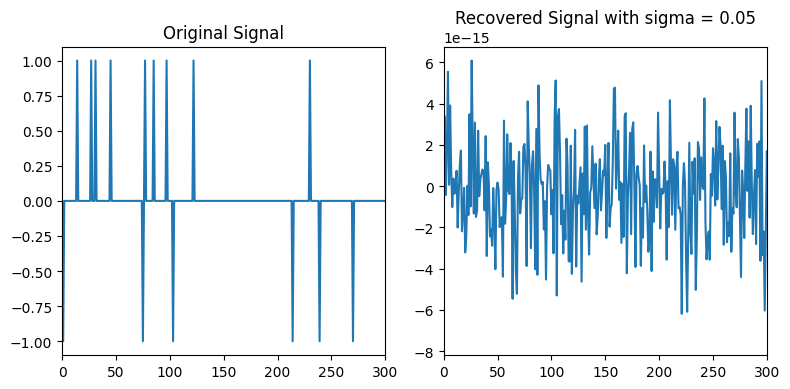

In [61]:
# Generate the recovered signal
sigma = 0.05
for j in range(num_trials):
    # Generate sparse 1D signals f0 with 50 nonzero components
    f0 = np.zeros(m) # 1024
    np.random.seed(0)
    indices = np.random.choice(m, k, replace=False)
    f0[indices] = np.random.choice([-1, 1], k)

    # Generate error e with desired mean and standard deviation
    mean_chi2 = sigma**2 * n  # mean of chi-square distribution
    std_chi2 = sigma**2 * np.sqrt(2*n)  # standard deviation of chi-square distribution
    e = np.random.randn(n) * sigma
    e_norm2 = np.linalg.norm(e)**2
    e *= np.sqrt(mean_chi2 / e_norm2)

    # Normalize e to have desired mean and standard deviation of chi-square distribution
    e_norm2 = np.linalg.norm(e)**2
    e *= np.sqrt(mean_chi2 / e_norm2)
    e *= std_chi2 / np.sqrt(e_norm2)

    # Solve Basis Pursuit Denoising problem
    epsilon = np.sqrt(sigma**2 * (n + lam*np.sqrt(2*n)))

    f = cp.Variable(m)
    objective = cp.Minimize(cp.norm(f, 1))
    constraints = [cp.norm(A @ f - A @ f0 - e, 2) <= epsilon]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

# Plot original and recovered signals
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(f0)
axs[0].set_title('Original Signal')
axs[0].set_xlim([0, n])
axs[1].plot(f.value)
axs[1].set_title('Recovered Signal with sigma = {}'.format(sigma))
axs[1].set_xlim([0, n])
plt.tight_layout()
plt.show()

#### Solve Basis Pursuit problem without noise

In [46]:
errors_bp = []
epsilons_bp = []
for sigma in sigmas:
    error_sum = 0
    for j in range(num_trials):
        # Generate sparse 1D signals f0 with 50 nonzero components
        f0 = np.zeros(m) # 1024
        indices = np.random.choice(m, k, replace=False)
        f0[indices] = np.random.choice([-1, 1], k)

        # Solve Basis Pursuit Denoising problem
        epsilon = np.sqrt(sigma**2 * (n + lam*np.sqrt(2*n)))
        
        f = cp.Variable(m)
        objective = cp.Minimize(cp.norm(f, 1))
        constraints = [cp.norm(A @ f - A @ f0, 2) <= epsilon]
        prob = cp.Problem(objective, constraints)
        prob.solve()

        # Compute error
        try:
            if f.value is not None:
                error = np.linalg.norm(f0 - f.value, 2) / np.linalg.norm(f0, 2)
                error_sum += error
            else:
                print("Optimization problem did not converge.")
        except cp.error.SolverError:
            print("Solver error occurred. Please check the optimization problem formulation.")
        
        
    # Compute average error over all trials
    epsilons_bp.append(epsilon)
    errors_bp.append(error_sum / num_trials)

# Print results
print("sigmas:", sigmas)
print("epsilons:", epsilons_bp)
print("errors:", errors_bp)


sigmas: [0.01 0.02 0.05 0.1  0.2  0.5 ]
epsilons: [0.18681268555846617, 0.37362537111693234, 0.9340634277923309, 1.8681268555846617, 3.7362537111693235, 9.340634277923309]
errors: [1.0440050429894006, 1.0140090079137192, 1.0000000000000013, 1.0000000000000004, 1.0000000000000002, 1.0000000000000002]


#### Difeerent matrix
Construct another matrix with the same singular vectors as $A$ above but where the singular spectrum is changed to $exp(-k/100)$.

In [47]:
# construct another matrix with the same singular vectors as A but with a different singular spectrum
# singular values are decreasing exponentially with a decay rate of 100
W2 = np.diag(np.exp(-np.arange(300)/100)) #(300, 300)
A2 = np.dot(np.dot(U, W2), V.T) #(300, 1024)

errors_A2 = []
epsilons_A2 = []

for sigma in sigmas:
    error_sum = 0
    for j in range(num_trials):
        # Generate sparse 1D signals f0 with 50 nonzero components
        f0 = np.zeros(m) # 1024
        np.random.seed(0)
        indices = np.random.choice(m, k, replace=False)
        f0[indices] = np.random.choice([-1, 1], k)

        # Generate error e with desired mean and standard deviation
        mean_chi2 = sigma**2 * n  # mean of chi-square distribution
        std_chi2 = sigma**2 * np.sqrt(2*n)  # standard deviation of chi-square distribution
        e = np.random.randn(n) * sigma
        e_norm2 = np.linalg.norm(e)**2
        e *= np.sqrt(mean_chi2 / e_norm2)

        # Normalize e to have desired mean and standard deviation of chi-square distribution
        e_norm2 = np.linalg.norm(e)**2
        e *= np.sqrt(mean_chi2 / e_norm2)
        e *= std_chi2 / np.sqrt(e_norm2)

        # Solve Basis Pursuit Denoising problem
        epsilon = np.sqrt(sigma**2 * (n + lam*np.sqrt(2*n)))
        
        f = cp.Variable(m)
        objective = cp.Minimize(cp.norm(f, 1))
        constraints = [cp.norm(A2 @ f - A2 @ f0 - e, 2) <= epsilon]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.ECOS)

        # Compute error
        try:
            if f.value is not None:
                error = np.linalg.norm(f0 - f.value, 2) / np.linalg.norm(f0, 2)
                error_sum += error
            else:
                print("Optimization problem did not converge.")
        except cp.error.SolverError:
            print("Solver error occurred. Please check the optimization problem formulation.")
        
        
    # Compute average error over all trials
    epsilons_A2.append(epsilon)
    errors_A2.append(error_sum / num_trials)

# Print results
print("sigmas:", sigmas)
print("epsilons:", epsilons_A2)
print("errors:", errors_A2)

sigmas: [0.01 0.02 0.05 0.1  0.2  0.5 ]
epsilons: [0.18681268555846617, 0.37362537111693234, 0.9340634277923309, 1.8681268555846617, 3.7362537111693235, 9.340634277923309]
errors: [0.36800827349775195, 0.6278064738862581, 0.9226299168425756, 1.0000000000000007, 1.0000000000000013, 1.0000000000000002]


### Comments
Changing the singular spectrum of $A$ to $exp(-k/100)$ may reduce the stability of the signal recovery process using the corresponding matrix $A2$ compared to the original matrix $A$ with the singular spectrum $exp(-k/10)$. This is because the rate of decay of the singular values in $A2$ is slower than in $A$ (i.e. the exponent in $A2$ is smaller than in $A$), which implies that the higher singular values will have a greater impact on the reconstruction of $f$ in $A2$. Therefore, the recovery of $f$ from $A2$ may be less precise and more susceptible to noise and errors.